# Hummer-Szabo Projection

In [63]:
import msmhelper as mh
import numpy as np
import prettypyplot as pplt
from matplotlib import pyplot as plt
from msmhelper.utils import datasets
pplt.use_style(figsize=(6, 2.5), latex=False)

# rate of h, k
rates = ((0.2, 0.05), (0.1, 0.1), (0.1, 0.2))
trajs = {
    rate: {
        label: traj
        for label, traj in zip(
            ('micro', 'macro'),
            datasets.hummer15_8state(*rate, nsteps=int(1e5), return_macrotraj=True),
        )
    }
    for rate in rates
}

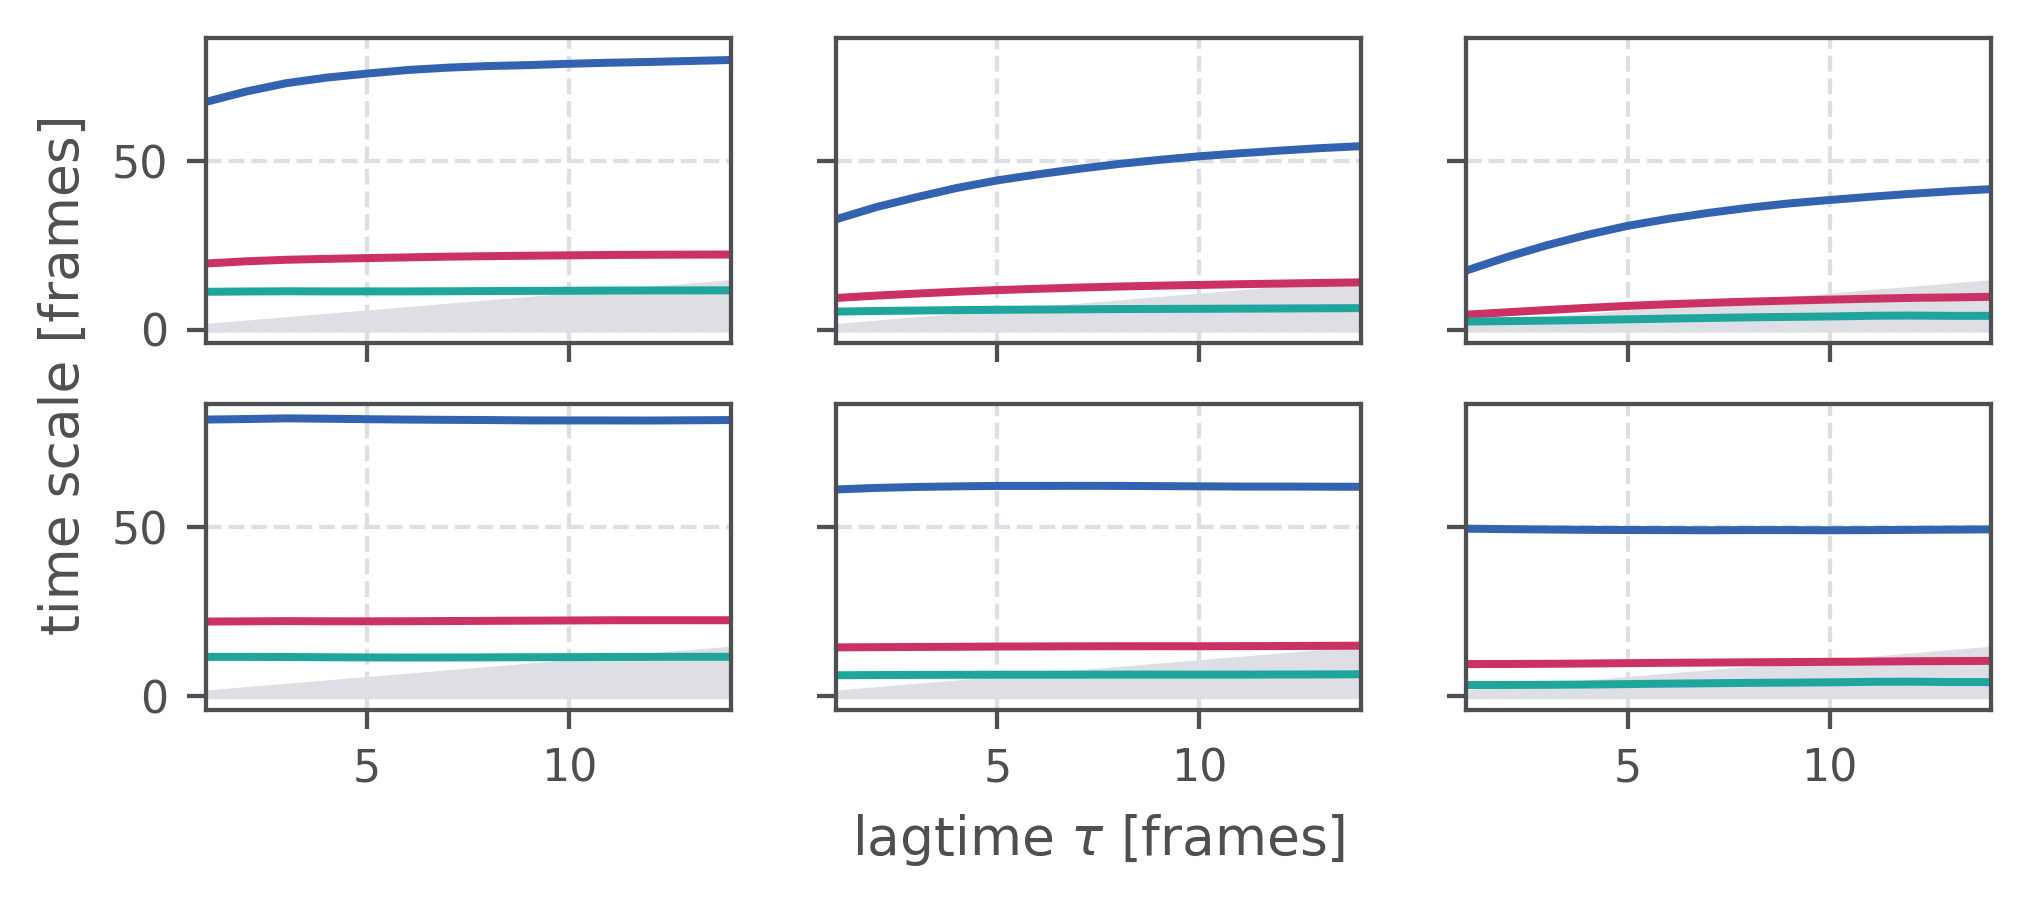

In [66]:
lagtimes = np.arange(1, 15)
_, axs = plt.subplots(2, len(rates), sharey=True, sharex=True)
for idx_rate, (rate, traj) in enumerate(trajs.items()):
    eq_traj = mh.StateTraj(traj['macro'])
    hummer_szabo_traj = mh.LumpedStateTraj(traj['macro'], traj['micro'])
    
    for idx_macro, macrotraj in enumerate((eq_traj, hummer_szabo_traj)):
        ax = axs[idx_macro, idx_rate]
        
        impl_times = mh.msm.implied_timescales(macrotraj, lagtimes, ntimescales=3)
        for idx, impl_time in enumerate(impl_times.T):
            ax.plot(lagtimes, impl_time, label=f'$t_{idx + 1}$')
        
        ax.set_xlim(lagtimes[0], lagtimes[-1])
        # highlight diagonal
        ax.fill_between(ax.get_xlim(), ax.get_xlim(), color='pplt:grid')

pplt.subplot_labels(
    xlabel=r'lagtime $\tau$ [frames]',
    ylabel='time scale [frames]',
)

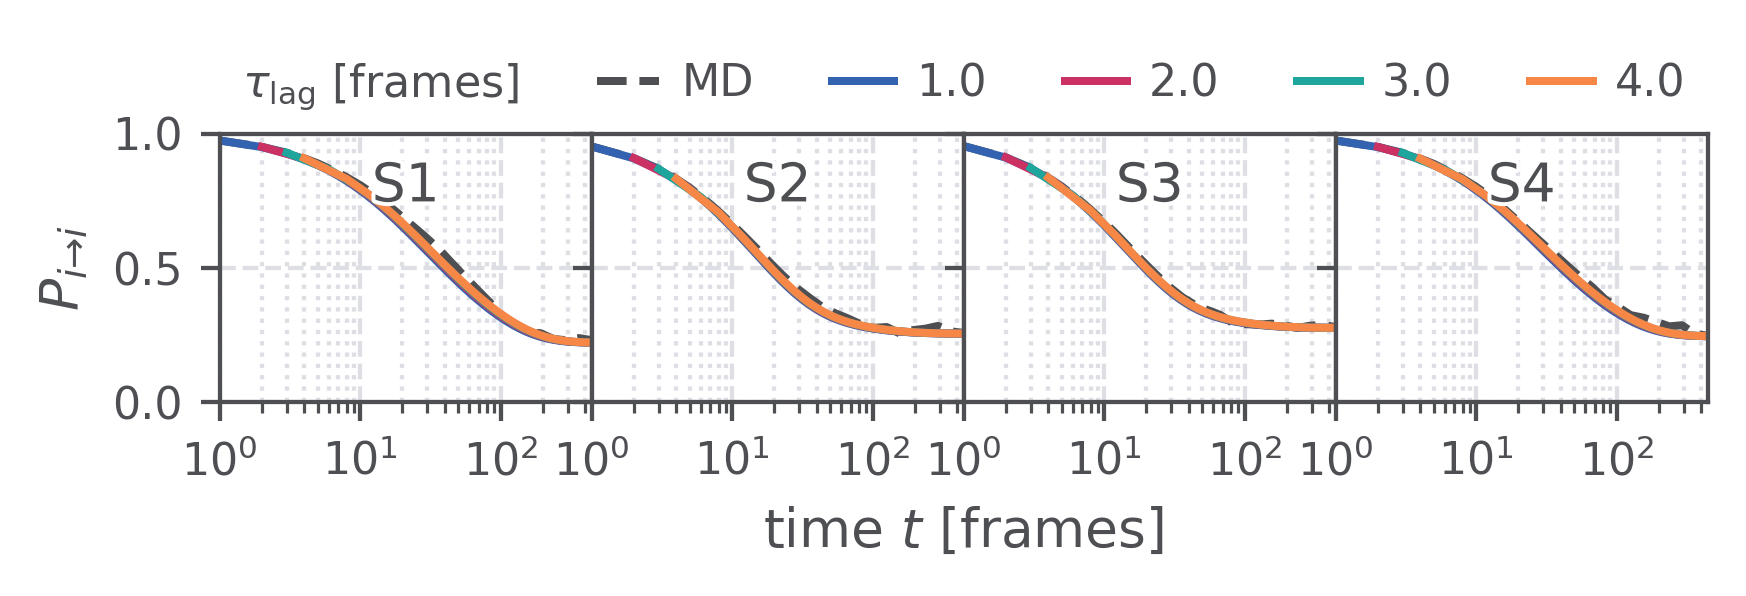

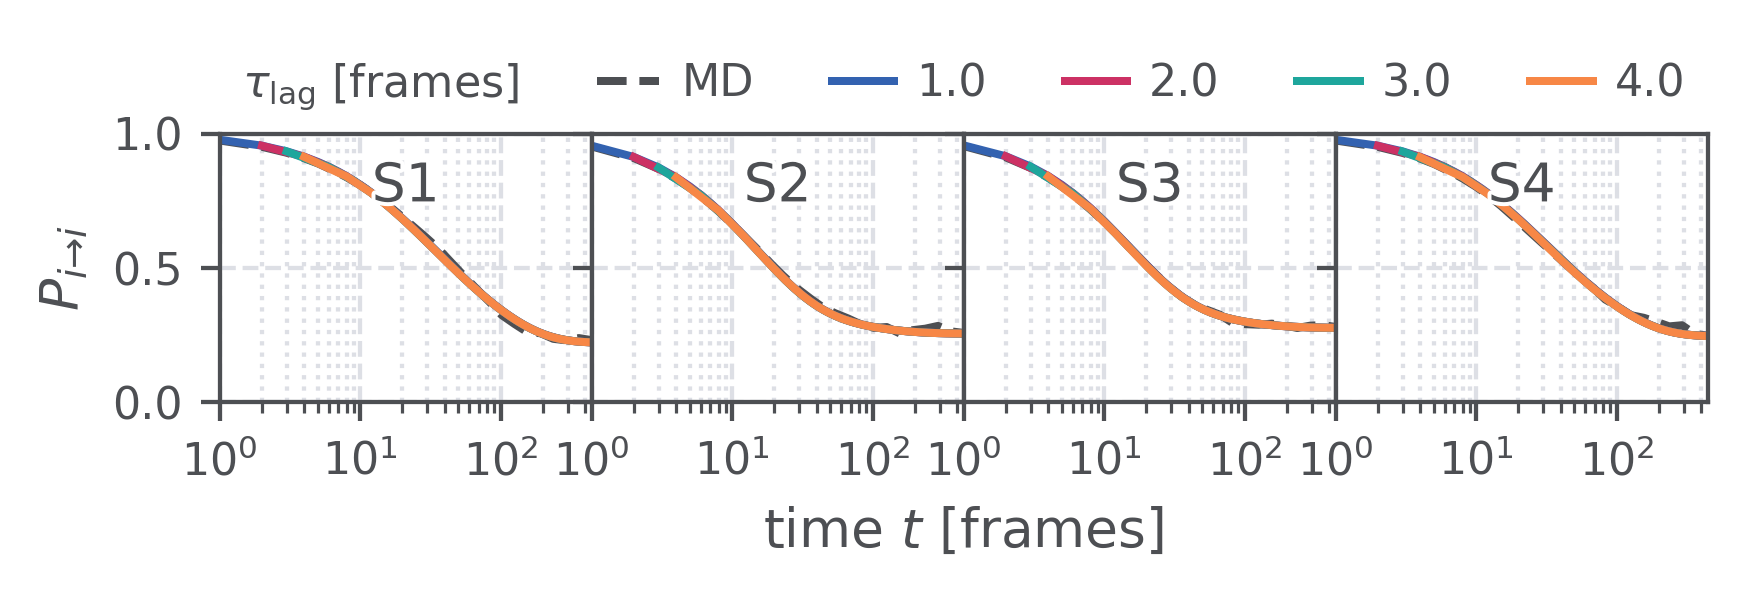

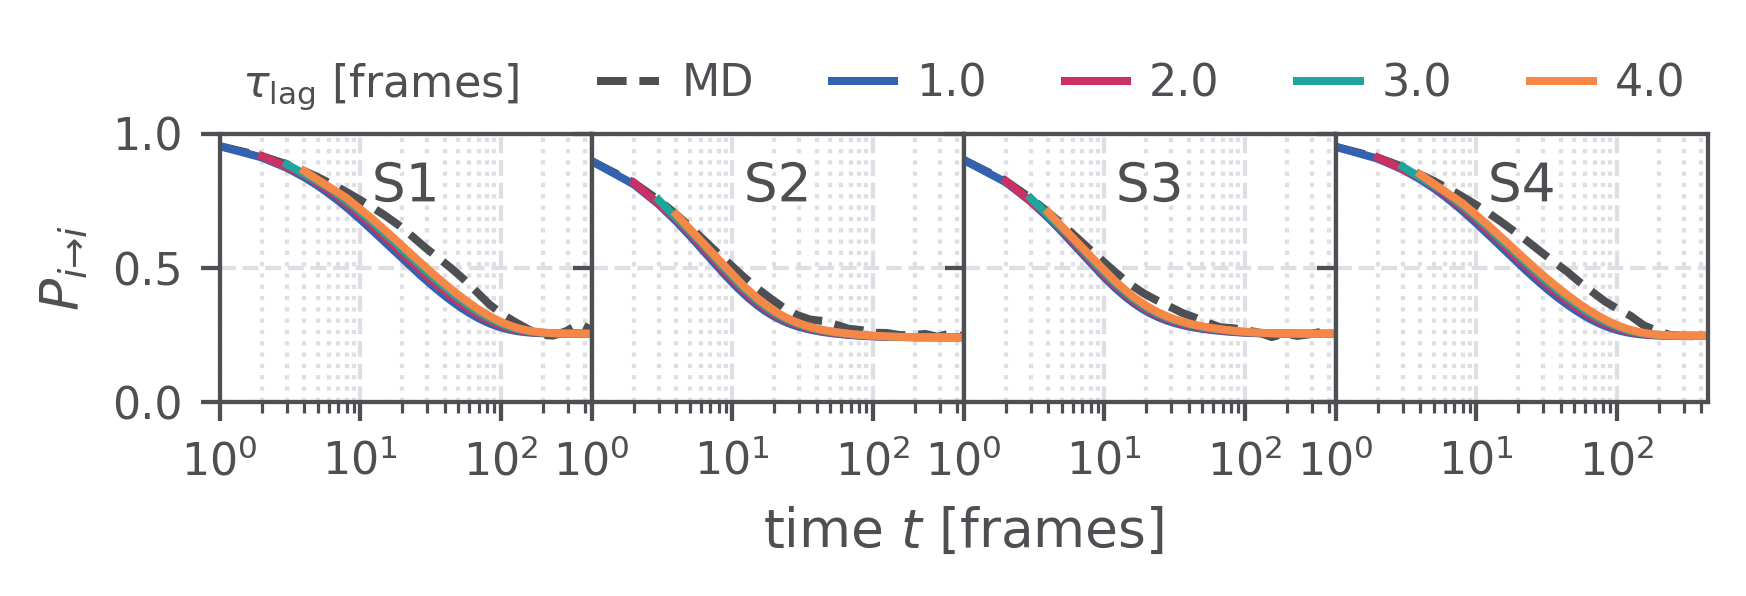

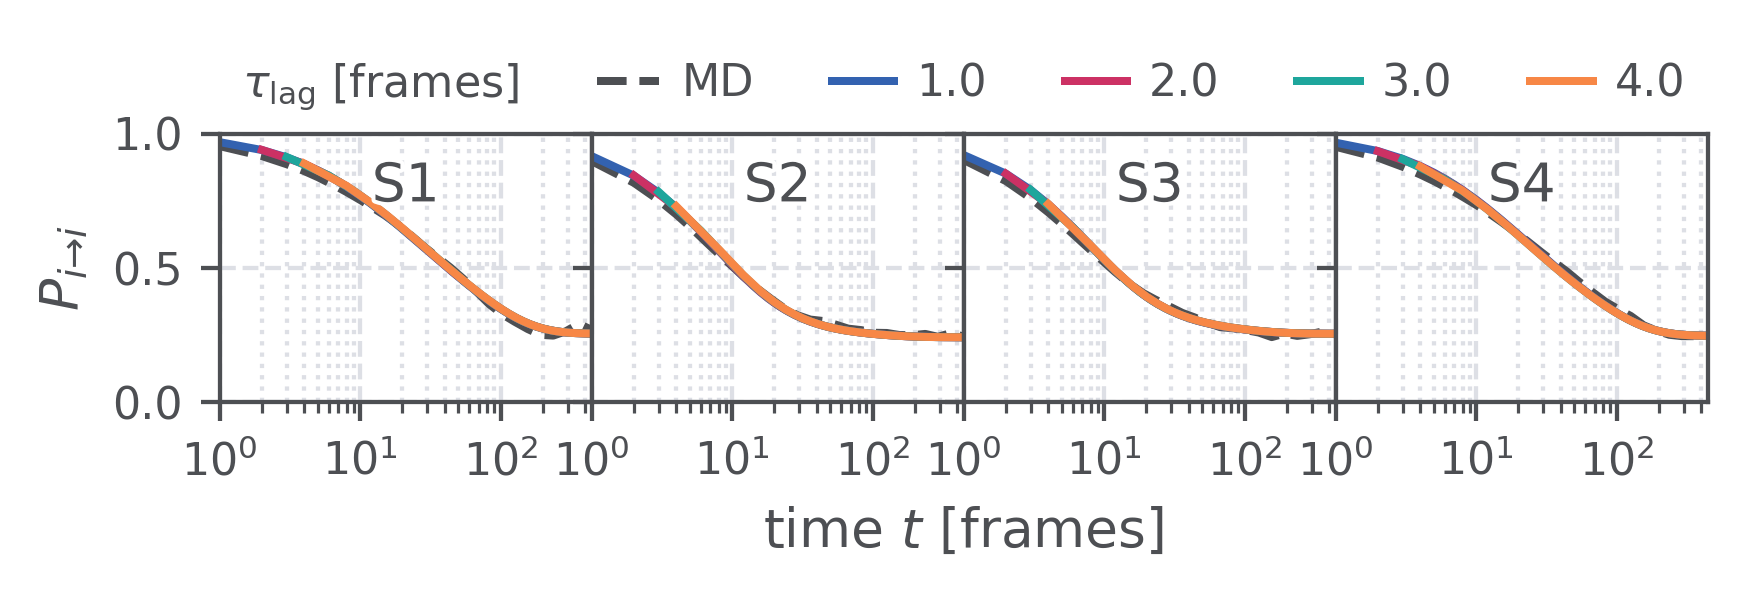

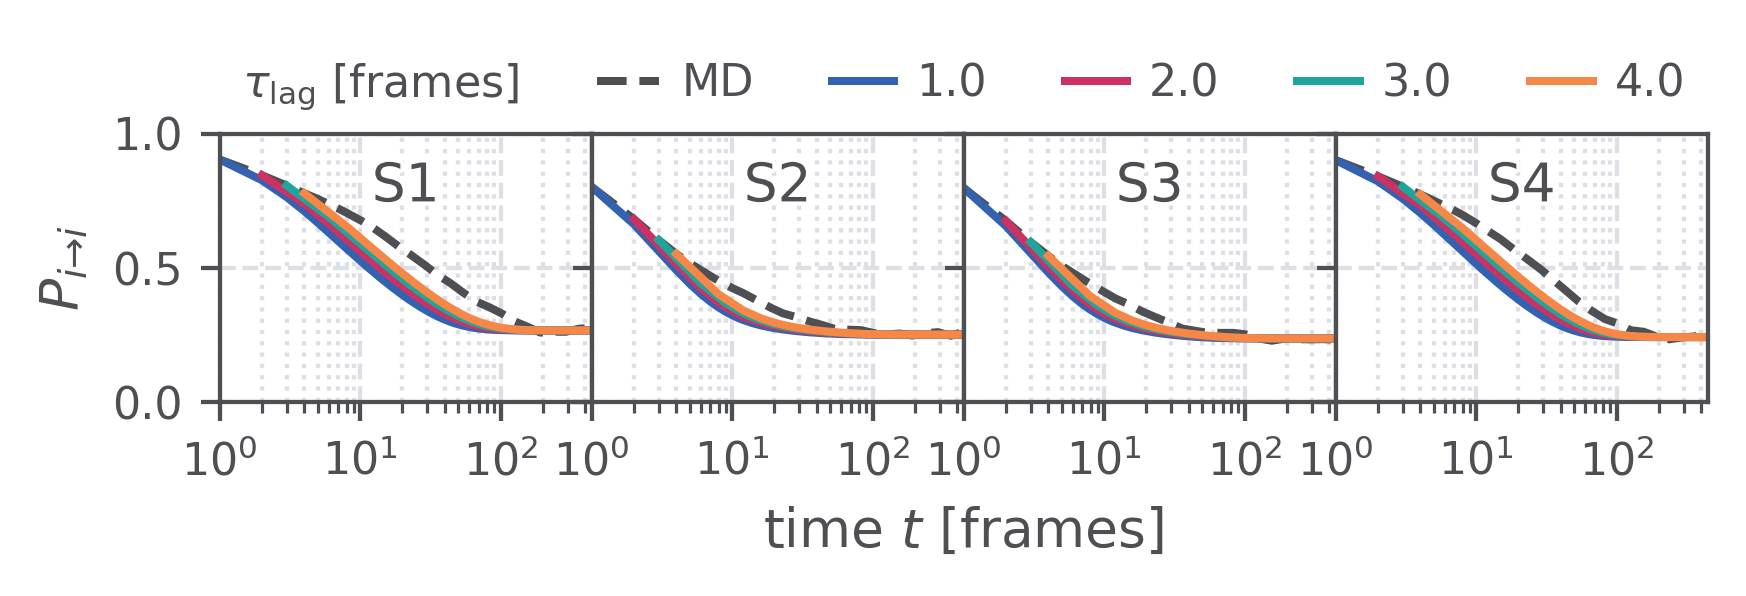

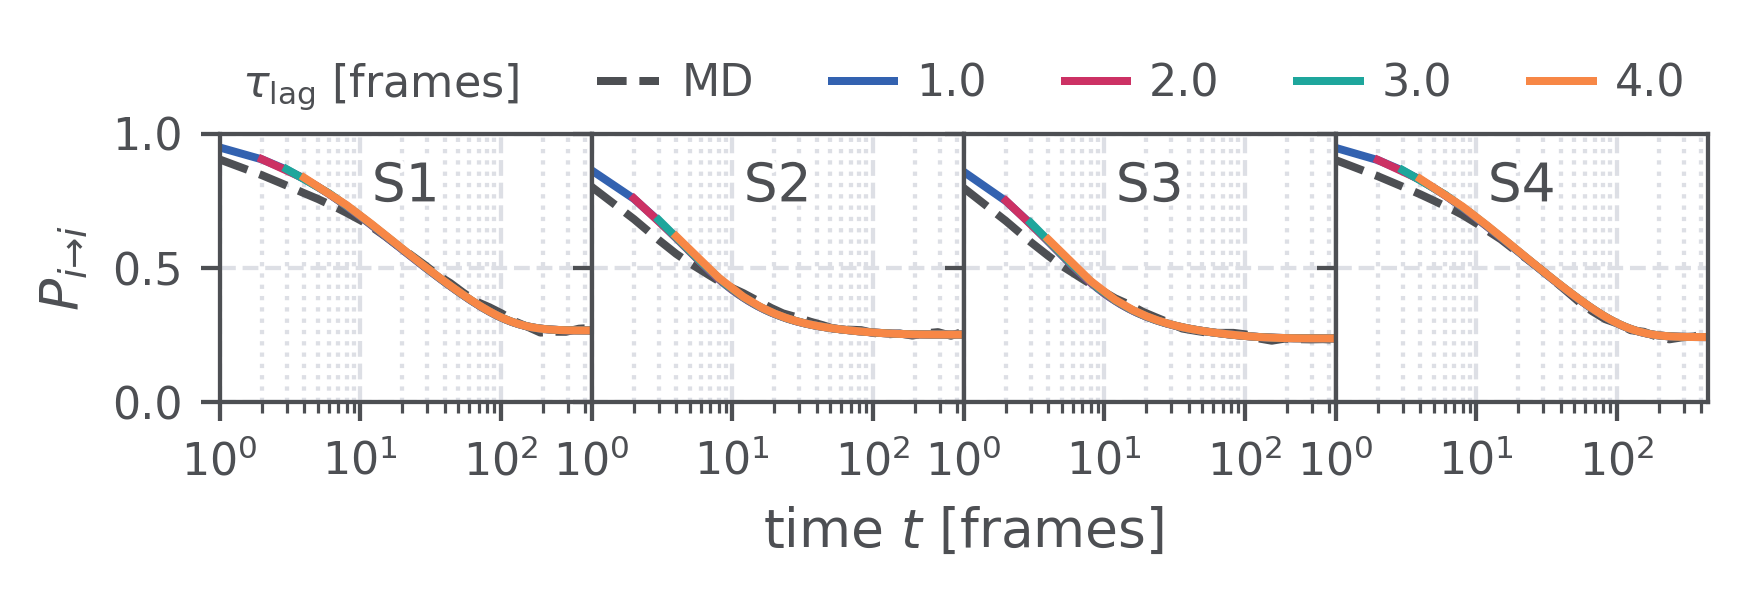

In [42]:
pplt.use_style(figsize=(5, 1.0), latex=False)
lagtimes = [1, 2, 3, 4]
tmax = 445

for rate, traj in trajs.items():
    eq_traj = mh.StateTraj(traj['macro'])
    hummer_szabo_traj = mh.LumpedStateTraj(traj['macro'], traj['micro'])
    
    for macrotraj in (eq_traj, hummer_szabo_traj):
        ck = mh.msm.ck_test(macrotraj, lagtimes, tmax)
        mh.plot.plot_ck_test(ck=ck, grid=(1, 4))